In [2]:
import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
repo_path = '/cluster/tufts/hugheslab/eharve06/bdl-transfer-learning'
experiments_path = os.path.join(repo_path, 'experiments/HAM10000')

In [4]:
def get_df(path):
    df = pd.read_csv(path, index_col='Unnamed: 0')
    return df

def get_best_epoch(df, window_size):
    val_auroc = np.array(df.val_auroc.to_list())
    windowed_auroc = [sum(val_auroc[index-window_size:index])/window_size \
                      for index in range(window_size, len(val_auroc))]
    return df.iloc[window_size+np.argmax(windowed_auroc)]

In [5]:
random_states = [1001, 2001]
prior_scales = np.logspace(5, 9, num=5)
lr_0s = np.logspace(-1, -4, num=4)
weight_decays = np.append(np.logspace(-2, -6, num=5), 0)
window_size = 5

In [6]:
columns = ['random_state', 'prior_scale', 'test_auroc', 'test_loss', 'test_nll', 
           'test_prior', 'train_auroc', 'train_loss', 'train_nll', 'train_prior', 
           'val_auroc', 'val_loss', 'val_nll', 'val_prior']
df = pd.DataFrame(columns=columns)

for row_index, (random_state, prior_scale) in enumerate(itertools.product(random_states, prior_scales)):    
    # Get best model
    best_row = None
    for lr_0, weight_decay in itertools.product(lr_0s, weight_decays):
        df_path =  '{}/random_state={}/learned_prior_scale={}_lr_0={}_weight_decay={}.csv'\
        .format(experiments_path, random_state, prior_scale, lr_0, weight_decay)
        row = get_best_epoch(get_df(df_path), window_size=window_size)
        if best_row is None: best_row = row
        if row['val_auroc'] > best_row['val_auroc']: best_row = row
    # Append best_model to df
    row = [random_state, prior_scale, best_row.test_auroc, best_row.test_loss, 
           best_row.test_nll, best_row.test_prior, best_row.train_auroc, 
           best_row.train_loss, best_row.train_nll, best_row.train_prior, 
           best_row.val_auroc, best_row.val_loss, best_row.val_nll, 
           best_row.val_prior]
    df.loc[row_index] = row
# Average across prior_scales
df = df.groupby('prior_scale').agg(lambda x: list(x))
columns = ['test_auroc', 'test_loss', 'test_nll', 'test_prior', 
           'train_auroc', 'train_loss', 'train_nll', 'train_prior', 
           'val_auroc', 'val_loss', 'val_nll', 'val_prior']
for column in columns:
    df[column] = df[column].apply(lambda item: np.mean(item))
df.random_state = df.random_state.apply(lambda item: 'mean')
df = df.reset_index()

In [7]:
df.head()

,prior_scale,random_state,test_auroc,test_loss,test_nll,test_prior,train_auroc,train_loss,train_nll,train_prior,val_auroc,val_loss,val_nll,val_prior
0,1.000000e+05,mean,0.889878,3.569804e+05,0.919896,-3.569795e+05,1.0,42712.599609,0.000287,-42712.599609,0.907439,3.551685e+05,0.940138,-3.551676e+05
1,1.000000e+06,mean,0.893595,6.312436e+05,1.058019,-6.312425e+05,1.0,75528.183594,0.000067,-75528.183594,0.917202,6.280395e+05,0.922084,-6.280386e+05
2,1.000000e+07,mean,0.888161,9.110203e+05,0.946925,-9.110194e+05,1.0,109003.484375,0.000088,-109003.484375,0.910258,9.063965e+05,1.073200,-9.063954e+05
3,1.000000e+08,mean,0.886282,1.191419e+06,0.903424,-1.191418e+06,1.0,142553.260288,0.002701,-142553.257812,0.912233,1.185372e+06,0.886579,-1.185371e+06
4,1.000000e+09,mean,0.905352,1.471882e+06,0.937942,-1.471882e+06,1.0,176110.656250,0.000239,-176110.656250,0.910797,1.464412e+06,0.932087,-1.464411e+06


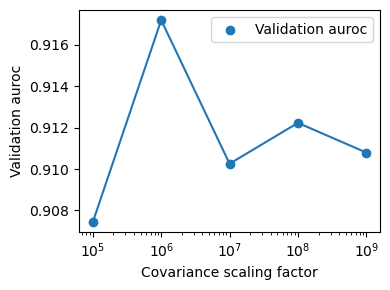

In [8]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4, 3))
ax.scatter(df.prior_scale, df.val_auroc, label='Validation auroc')
ax.plot(df.prior_scale, df.val_auroc)
ax.set_xscale('log')
ax.set_xlabel('Covariance scaling factor')
ax.set_ylabel('Validation auroc')
ax.legend()
fig.tight_layout()
plt.show()

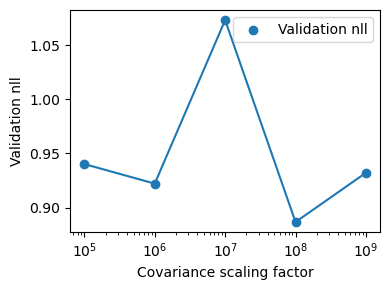

In [9]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4, 3))
ax.scatter(df.prior_scale, df.val_nll, label='Validation nll')
ax.plot(df.prior_scale, df.val_nll)
ax.set_xscale('log')
ax.set_xlabel('Covariance scaling factor')
ax.set_ylabel('Validation nll')
ax.legend()
fig.tight_layout()
plt.show()